# Developing Pyreal Applications

In this tutorial, we will be going through the process of putting together a RealApp object for future use.

If you have not already tried Demonstration 1: Using Pyreal, please do so before trying this demo, to better understand the purpose of RealApp objects.

## Scenario Details
### Goals for this Scenario
1. Learn the components of a Pyreal RealApp, and the steps required to create one for your target application
2. Learn about Pyreal's built-in Transformers, and how to make custom, application-specific transformers

### User Details

- **User Role:** ML Engineer for Real Estate Firm
- **Expertise:**
    - **Domain (House Pricing):** Some experience
    - **Machine Learning:** Expert
    - **Explainable ML techniques:** Basic understanding
- **User Goals:**
    1. Understand what features contribute to average block prices in California

### Model and Data Details
- 9 Features
- Predicts average price of block of houses

## Data Loading

We will begin by loading in our data matrix and targets, and taking a look at the data


In [1]:
from pyreal.sample_applications import california_housing
import pandas as pd

X, y = california_housing.load_data()
X.sample(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
5333,-118.45,34.04,19,3330,1010.0,1837,915,3.0173,<1H OCEAN
11569,-118.01,33.77,33,1387,238.0,890,264,5.4220,<1H OCEAN
19768,-122.00,39.94,27,852,176.0,464,148,1.7125,INLAND
17185,-122.43,37.43,17,11999,2249.0,5467,1989,4.8405,NEAR OCEAN
11808,-121.11,38.91,24,2558,423.0,1149,403,4.0679,INLAND


## Current State: Explaining Without Pyreal
Let's start by fitting some transformers, training a model, and trying to generate a global explanation of our model without using Pyreal, so we have a point of comparison for both coding effort and explanation quality over just using ML and explanation algorithms directly.

First, we transform the data and train a basic Perceptron...

In [2]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

X_transform = X.copy()

# One-hot encode ocean_proximity to be compatible with model
ohe = OneHotEncoder(sparse_output=False)
ohe_cols = ohe.fit_transform(X_transform[["ocean_proximity"]])
ohe_cols_df = pd.DataFrame(ohe_cols)
column_names = ohe.get_feature_names_out(["ocean_proximity"])
ohe_cols_df.columns = column_names
X_transform = X_transform.drop("ocean_proximity", axis="columns")
X_transform = pd.concat([X_transform, ohe_cols_df], axis=1)

# Impute data to be compatible with model
imp = SimpleImputer(strategy="mean")
imputed_bedrooms = imp.fit_transform(X_transform[["total_bedrooms"]])
X_transform["total_bedrooms"] = imputed_bedrooms

# Add additional columns
X_transform["average_rooms"] = X_transform["total_rooms"] / X_transform["households"]
X_transform["average_bedrooms"] = X_transform["total_bedrooms"] / X_transform["households"]

columns = X_transform.columns

# Scale data to improve model performance
X_train, X_test, y_train, y_test = train_test_split(X_transform, y, random_state=1)
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=columns) # We use DataFrame here to maintain feature names (column names)
X_test = pd.DataFrame(scaler.transform(X_test), columns=columns)

expected_column_order = X_train.columns

# Train model
model = MLPRegressor(hidden_layer_sizes=(50, 50),
                     max_iter=1000, solver="lbfgs", alpha=0.001).fit(X_train, y_train)
print("R^2 Score:", model.score(X_test, y_test))

R^2 Score: 0.793162314173221


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


... And then we can use SHAP to generate a beeswarm plot explanation of the data

Permutation explainer: 501it [01:38,  5.04it/s]                         


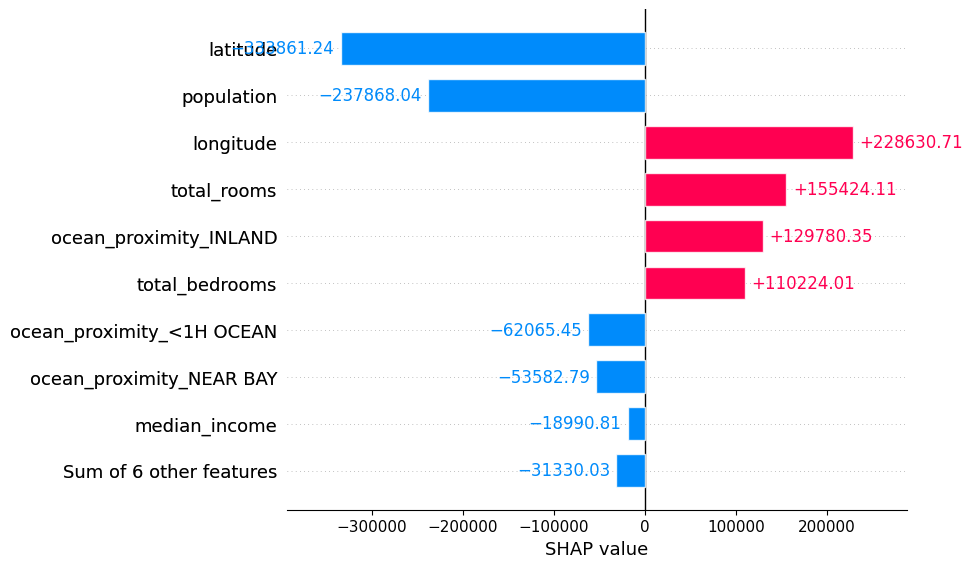

In [3]:
import shap

explainer = shap.Explainer(model.predict, X_train[0:500])
shap_values = explainer(X_train[0:500])
shap.plots.bar(shap_values[0])

Here, each point represents a row in our dataset. The farther right a point is, the more that specific feature value in that row *increased* the model prediction. The farther left a point is, the more that specific feature value in that row *decreased* the model prediction. The points are colored by feature value, with blue points representing a higher value.

For example, we can see from this plot that higher latitudes and longitudes correspond to higher house prices. Similarly, blocks with fewer total rooms or higher populations are more expensive.

## Developing Pyreal Applications: Model Transformers
Often, data needs to be transformed before being passed into a machine learning model, either to improve performance or to format it to be supported by the model architecture. For example, in the code cells above we had to one-hot encode, impute, and standardize our data in order to make model predictions on it.

Unfortunately, these kinds of transformation can make explanations hard to parse. For example, in the explanation above, we need to consider every `ocean_proximity` child feature together to get the total contribution of the actual block proximity to the ocean. Additionally, values are given are standardized values, which is difficult to parse.

By replacing these transformers with the Pyreal built-in equivalents, our explanations will be automatically presented with these muddling transformations undone. Additionally, the `MultiTypeImputer` transformer automatically imputes all columns with an appropriate strategy.

In [4]:
from pyreal.transformers import OneHotEncoder, MultiTypeImputer, DataFrameWrapper, FeatureSelectTransformer

# Initialize and fit transformers using fit_transformers
transformers = [MultiTypeImputer(),
                OneHotEncoder(columns="ocean_proximity")]

While Pyreal offers many common transformer types, sometimes our specific domains may require a more specific transformer option. Luckily, Pyreal makes it easy to add new *custom transformers*. Let's start with a basic one.

Below, we define the `PerHouseHoldAverager`. Pyreal Transformers extend the base `Transformer` class (line 3). They then define, at minimum, a `data_transform` function. This function acts just like the `.transform()` function of the sklearn transformers we used above - it takes in a dataframe, and returns the dataframe with one or more features transformed. In this case, our transformer adds a new column, with the per-household average of the requested features.

In [5]:
from pyreal.transformers import Transformer

class PerHouseholdAverager(Transformer):
    def __init__(self, columns, **kwargs):
        """
        Args:
            columns (list of strings)
                The names of the columns to average
        """
        self.columns = columns
        super().__init__(**kwargs)

    def data_transform(self, x):
        """
        Transform the data by adding a new column from total_[column] called average_[column].
        This feature represents the average value of [column] per household.

        Args:
            x (DataFrame)
                The data to transform
        """
        for column in self.columns:
            name = column.replace("total", "average")
            x[name] = x[column] / x["households"]
        return x

Let's go ahead and add that transformer to our list. You may notice the `interpret` flag in our initialization. This flag tells Pyreal that this transformation improves the *interpretability* of the resulting data - or in other words, changes the presentation of the data in such a way that makes it easier to reason about (or at least, not more difficult).

In this case, we are adding features (`average_rooms` and `average_bedrooms`) that we expect will be very easy for our users to reason about, so we do not need to undo this transformation.

In [6]:
transformers.append(PerHouseholdAverager(columns=["total_bedrooms", "total_rooms"], interpret=True))

Sometimes, there may be a way to make the data even more interpretable (ie, easy to reason about) than the original data, but that for whatever reason we do not want to or cannot make this change to the data being fed into the model.

For example, the latitude and longitude features above are hard to reason about for most people. Something like a city or neighborhood name would be better, but trying to one-hot encode every neighborhood in California to feed into the model would be a massive memory drain. Instead, we will continue giving the model the `longitude`/`latitude` features, but we will then transform the *explanation* to use this more interpretable feature.

To do so, we will use another transformer. Take a look at the definition below; we will then walk through it step-by-step

In [7]:
from pyreal.types.explanations.feature_based import AdditiveFeatureImportanceExplanation, AdditiveFeatureContributionExplanation

def helper_sum_lat_long_columns(explanation):
    """
    In the case of additive contributions or importances, we can combine the latitude and
    longitude explanation contributions by summing to get the city contribution. In this
    case, our implementation is almost identical for both types of explanations
    """
    explanation_transform = explanation.copy()
    explanation_transform["neighborhood"] = explanation["longitude"] + explanation["latitude"]
    explanation_transform = explanation_transform.drop("longitude", axis=1)
    explanation_transform = explanation_transform.drop("latitude", axis=1)
    return explanation_transform

class CityConverter(Transformer):
    def __init__(self, **kwargs):
        self.cities = california_housing.load_city_data()
        super().__init__(**kwargs)

    def data_transform(self, x):
        """
        Converts latitude/longitude coordinates to closest city name. Note that
        we are using a very rough estimate here, for illustrative purposes, rather than
        a more complicated but accurate nearest neighbor search
        Args:
            x (DataFrame)
                The data to transform
        """
        for index, row in self.cities.iterrows():
            lat = row["Latitude"]
            lon = row["Longitude"]
            x.loc[(x["latitude"] > lat-0.1) & (x["latitude"] < lat+0.1) & (x["longitude"] > lon-0.1) & (x["longitude"] < lon+0.1), "neighborhood"] = row["Name"]
        x = x.drop("latitude", axis=1)
        x = x.drop("longitude", axis=1)
        return x

    def transform_explanation_additive_feature_contribution(self, explanation):
        """
        Combines the contributions of the latitude and longitude features for
        additive local feature contribution explanations.
        Args:
            explanation (AdditiveFeatureImportanceExplanation)
                The explanation to transform
        """
        df = explanation.get()  # A DataFrame with one row per instance and one column per feature
        return AdditiveFeatureContributionExplanation(helper_sum_lat_long_columns(df))

    def transform_explanation_additive_feature_importance(self, explanation):
        """
        Combines the importance of the latitude and longitude features for
        additive local feature importance explanations.
        Args:
            explanation (AdditiveFeatureImportanceExplanation)
                The explanation to transform
        """
        df = explanation.get()  # A DataFrame with one row and one column per feature
        return AdditiveFeatureImportanceExplanation(helper_sum_lat_long_columns(df))

You are already familiar with the first two class methods in the `CityConverter` above:

- [`init()`]: When initializing the transformer, we will load in a DataFrame connecting lat/long values with neighborhood names.
- [`data_tranform()`]: The `data_transform` function converts the `latitude` and `longitude` columns in data into a `neighborhood` column using a simple algorithm.

The next two functions are used to transform explanations. Explanation transform functions take in explanations objects of a specific type or category of types, and return the explanation transformed based on this transformer. We can write one explanation transform function per explanation output type:

- [`transform_explanation_additive_feature_contribution`]: This function combines the contributions of the latitude and longitude features to get the contribution of the neighborhood feature. Because we only apply this transform to *additive* contributions, we can assume the contribution of a combination feature to be the sum of the original features.
- [`transform_explanation_additive_feature_importance`]: This function is very similar to the previous, but acts on additive global importance explanations instead of local contributions.

<div class="alert alert-block alert-info" style="background-color: white; border: 2px solid; padding: 10px">
    <b><i class="fa fa-info-circle" aria-hidden="true"></i>&nbsp; Note</b><br>
    <p style="color: black">
         Note that explanation output types are heirarchial, and Pyreal will use the explanation transforms of higher-level types when the lower-level types are not available. For example, if <code>transform_explanation_additive_feature_contribution</code> is not defined, Pyreal will attempt to use <code>transform_explanation_feature_contribution</code>.
    </p>
</div>

In [8]:
transformers.append(CityConverter(interpret=True, model=False))

Once again, we use the `interpret` flag to indicate that this transformation makes our data more interpretable. We also add the `model=False` flag, to indicate that we should **not** apply this model when making model predictions.

We will also add two additional Pyreal built-in transformers, to improve model performance. Pyreal transformers are run in the order they appear in the transformer list, so we need to be careful about our order. The `DataFrameWrapper` wraps a standard scaler, allowing us to standardize all features while maintaining the DataFrame data type and column names. Finally, the `FeatureSelectTransformer` will reorder columns to ensure they are in the order expected by the model.


### Custom Transformers: Summary

In summary, when defining custom Pyreal transformers, we take the following steps:
1. Define the transformer `__init__()` method, using a `super()` call for the parent `Transformer` class. The function can take optional arguments to configure the transformer.
2. Define the `data_transform()` function, which takes an input DataFrame `x` and returns `x` after undergoing the transformation.
3. Consider the explanation output types you are interested in, and define the appropriate explanation transforms. In the above example, we considered additive local feature contribution and additive global feature importance explanations. We therefore defined the `transform_explanation_additive_feature_contribution` and `transform_explanation_additive_feature_importance` functions.
4. [**Advanced Additional Step**]: The explanation transform functions used above are used to transform the explanation to match the feature space resulting from the data transform function. In some cases, like in Pyreal's built-in one-hot encoder transformer, we may want to *undo* the transformation in the explanation. In these cases, we would define `inverse_transform_explanation_XXX` functions. See the Pyreal documentation for more details about this.

## Initializing RealApps

Now that we have our model transformers, we can gather the other components of the application:
 - [`model`]: We train our machine learning model using the external system of our choice.
 - [`feature_descriptions`]: This optional parameter is dictionary of feature names (ie, the data columns) to descriptions, which we can use if our feature names are not naturally readable.

In [9]:
from pyreal import RealApp

transformers.append(DataFrameWrapper(StandardScaler()))
transformers.append(FeatureSelectTransformer(columns=expected_column_order))

feature_descriptions = california_housing.load_feature_descriptions()
print(feature_descriptions)

realApp = RealApp(model, X_train_orig=X, transformers=transformers, fit_transformers=True, feature_descriptions=feature_descriptions)

{'longitude': 'Longitude', 'latitude': 'Latitude', 'housing_median_age': 'Median house age', 'total_rooms': 'Total Number of Rooms', 'total_bedrooms': 'Total Number of Bedrooms', 'population': 'Population', 'households': 'Number of Households', 'median_income': 'Median Income', 'ocean_proximity': 'Proximity to Ocean', 'neighborhood': 'Neighborhood'}
fitting transformers


[TODO: go through a few explanations with the new realapp]

In [10]:
realApp.predict(X[:10])

{0: 425365.3122398248,
 1: 404524.72225775267,
 2: 377123.21113717655,
 3: 268068.5560315368,
 4: 260975.69355469669,
 5: 193683.8682325269,
 6: 232718.03564104356,
 7: 312823.6061608535,
 8: 169242.25741436356,
 9: 246991.02136374815}

X does not have valid feature names, but MLPRegressor was fitted with feature names
Using 150 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
X does not have valid feature names, but MLPRegressor was fitted with feature names
Using 150 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

X does not have valid feature names, but MLPRegressor was fitted with feature names
X does not have valid feature names, but MLPRegressor was fitted with feature names


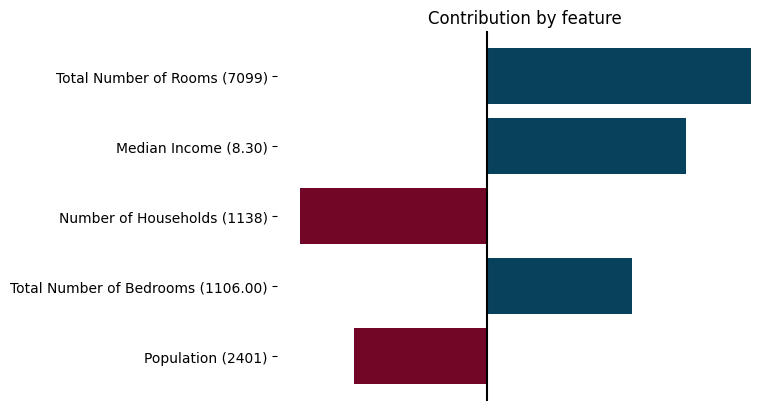

In [11]:
from pyreal import visualize

explanation = realApp.produce_local_feature_contributions(X.iloc[1], shap_type="kernel", training_size=150)
visualize.plot_top_contributors(explanation[0], select_by="absolute", show=True)

In [25]:
explanation = realApp.produce_local_feature_contributions(X.sample(100), shap_type="kernel", training_size=100)

  0%|          | 0/150 [00:00<?, ?it/s]

X does not have valid feature names, but MLPRegressor was fitted with feature names
X does not have valid feature names, but MLPRegressor was fitted with feature names
X does not have valid feature names, but MLPRegressor was fitted with feature names
X does not have valid feature names, but MLPRegressor was fitted with feature names
X does not have valid feature names, but MLPRegressor was fitted with feature names
X does not have valid feature names, but MLPRegressor was fitted with feature names
X does not have valid feature names, but MLPRegressor was fitted with feature names
X does not have valid feature names, but MLPRegressor was fitted with feature names
X does not have valid feature names, but MLPRegressor was fitted with feature names
X does not have valid feature names, but MLPRegressor was fitted with feature names
X does not have valid feature names, but MLPRegressor was fitted with feature names
X does not have valid feature names, but MLPRegressor was fitted with featur